# Business Travel Principal Component Analysis (PCA) and Hierarchical Clustering

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
from sklearn.metrics import (r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error)
from sklearn.preprocessing import PowerTransformer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering
from IPython.display import display

# Import business_travel dataframe
business_travel=pd.read_csv('business_travel.csv')

In [2]:
business_travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6060 entries, 0 to 6059
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_name                6060 non-null   object 
 1   account_id                  6060 non-null   int64  
 2   Year                        6060 non-null   int64  
 3   incorporated_country        6060 non-null   object 
 4   Primary activity            6060 non-null   object 
 5   Primary sector              6060 non-null   object 
 6   Market_Cap_USD              5034 non-null   float64
 7   Third_party_verification    6054 non-null   object 
 8   Revenue_USD                 5075 non-null   float64
 9   ebitda_USD                  5075 non-null   float64
 10  grossProfit_USD             5075 non-null   float64
 11  netIncome_USD               5075 non-null   float64
 12  cashAndCashEquivalents_USD  5075 non-null   float64
 13  shortTermInvestments_USD    5075 

In [3]:
business_travel.head()

,account_name,account_id,Year,incorporated_country,Primary activity,Primary sector,Market_Cap_USD,Third_party_verification,Revenue_USD,ebitda_USD,...,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_type,Scope_3_emissions_amount,scope_1_2_emissions_amount,Year_sq
0,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9.548124e+09,Third-party verification or assurance process ...,1.728470e+09,1.565910e+09,...,8.544560e+09,1.107567e+10,1.031240e+09,8.544560e+09,7.302500e+08,1.004443e+10,Business travel,2549.33,3.389500e+02,4072324
1,abrdn,17604,2018,United Kingdom,Insurance,Financial services,1.019344e+10,Third-party verification or assurance process ...,2.912110e+09,1.482090e+09,...,6.626860e+09,1.589659e+10,6.322060e+09,6.626860e+09,1.647190e+09,9.574530e+09,Business travel,15745.00,7.197250e+03,4072324
2,Antofagasta,820,2018,United Kingdom,Other non-ferrous ore mining,Metallic mineral mining,7.721230e+09,Third-party verification or assurance process ...,4.733100e+09,2.092800e+09,...,1.060800e+09,1.410250e+10,4.664400e+09,1.924000e+09,2.493900e+09,9.438100e+09,Business travel,5559.00,3.292186e+06,4072324
3,Aptiv,4407,2018,United Kingdom,Electrical equipment,Electrical & electronic equipment,1.595156e+10,No third-party verification or assurance,1.443500e+10,2.260000e+09,...,9.900000e+07,1.248000e+10,8.810000e+09,1.710000e+08,4.344000e+09,3.670000e+09,Business travel,33000.00,3.804718e+05,4072324
4,Arm Ltd.,950,2018,United Kingdom,Electronic components,Electrical & electronic equipment,NaN,No third-party verification or assurance,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Business travel,18001.70,7.728538e+03,4072324


In [4]:
# Rename features
business_travel = business_travel.rename(columns={'incorporated_country': 'Countries',
                                          'Primary activity': 'Primary_activity',
                                          'Primary sector': 'Primary_sector'})

# Drop unneeded columns
business_travel = business_travel.drop(
    ['Third_party_verification', 'Scope_3_emissions_type'], axis=1, errors='ignore')

business_travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6060 entries, 0 to 6059
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_name                6060 non-null   object 
 1   account_id                  6060 non-null   int64  
 2   Year                        6060 non-null   int64  
 3   Countries                   6060 non-null   object 
 4   Primary_activity            6060 non-null   object 
 5   Primary_sector              6060 non-null   object 
 6   Market_Cap_USD              5034 non-null   float64
 7   Revenue_USD                 5075 non-null   float64
 8   ebitda_USD                  5075 non-null   float64
 9   grossProfit_USD             5075 non-null   float64
 10  netIncome_USD               5075 non-null   float64
 11  cashAndCashEquivalents_USD  5075 non-null   float64
 12  shortTermInvestments_USD    5075 non-null   float64
 13  longTermInvestments_USD     5075 

In [5]:
# Looking at missing data
print(business_travel.isnull().mean().sort_values(ascending=False).round(3) * 100)

Market_Cap_USD                16.9
cashAndCashEquivalents_USD    16.3
totalLiabilities_USD          16.3
totalEquity_USD               16.3
totalDebt_USD                 16.3
Revenue_USD                   16.3
ebitda_USD                    16.3
grossProfit_USD               16.3
netIncome_USD                 16.3
totalInvestments_USD          16.3
shortTermInvestments_USD      16.3
longTermInvestments_USD       16.3
totalAssets_USD               16.3
scope_1_2_emissions_amount     0.3
Scope_3_emissions_amount       0.0
account_name                   0.0
account_id                     0.0
Primary_sector                 0.0
Primary_activity               0.0
Countries                      0.0
Year                           0.0
Year_sq                        0.0
dtype: float64


### PCA Feature Engineering — Business Travel Dataset

1. **Feature Selection**
    - Select numeric columns, excluding identifiers and categorical fields, for PCA input.
2. **Transformation**
    - Apply a signed-log transform to all numeric features to handle skewness and negative values.
3. **Missing Data Handling**
    - Drop rows with missing values in the transformed numeric data. Track indices for correct row alignment.
4. **Standardization**
    - Standardize the transformed data so each feature has mean 0 and variance 1.
5. **Principal Component Analysis**
    - Fit PCA on the standardized data using all valid numeric features.
    - Extract all principal components (`PC1`, `PC2`, ..., `PCn`).
6. **Integration**
    - Add the computed principal components back into the original DataFrame, aligning only to rows used in the PCA.
7. **Visualization**
    - Plot a scree plot (explained variance ratio by component).
    - Plot cumulative explained variance across components.
    - Print cumulative variance explained by each additional principal component.

---

**Result:**  
The final DataFrame, `business_travel_with_pcs`, includes the original business travel data plus all principal components for rows with complete numeric data. These features are ready for downstream analysis or modeling.

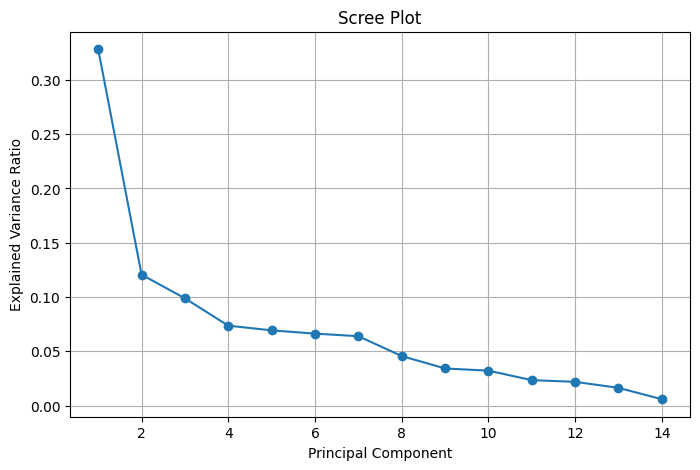

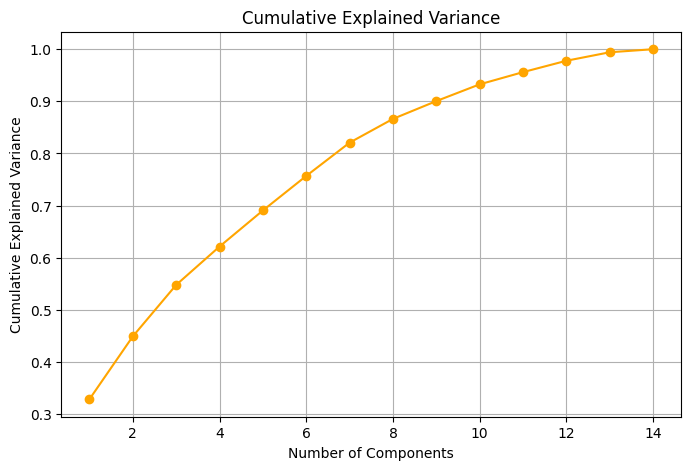

Cumulative variance explained by each additional principal component:
  PC1: 0.3283
  PC2: 0.4489
  PC3: 0.5477
  PC4: 0.6213
  PC5: 0.6905
  PC6: 0.7568
  PC7: 0.8207
  PC8: 0.8663
  PC9: 0.9005
  PC10: 0.9326
  PC11: 0.9560
  PC12: 0.9779
  PC13: 0.9942
  PC14: 1.0000


In [6]:
# --- STEP 1: Select appropriate columns for PCA ---
exclude_cols = [
    "account_id", "Year", "Year_sq",
    "account_name", "Countries", "Primary_activity", "Primary_sector"
]
numeric_cols = [
    col for col in business_travel.columns
    if col not in exclude_cols and pd.api.types.is_numeric_dtype(business_travel[col])
    and col != "Scope_3_emissions_amount"
]
X = business_travel[numeric_cols].copy()

# --- STEP 2: Apply sign-log transformation ---
def sign_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))
X_transformed = X.apply(sign_log_transform)

# --- STEP 3: Drop rows with missing values (keep track of indices) ---
X_dropped = X_transformed.dropna()
pca_indices = X_dropped.index

# --- STEP 4: Standardize the data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dropped)

# --- STEP 5: Fit PCA ---
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# --- STEP 6: Create a DataFrame for PCs, index matches original ---
num_pcs = X_pca.shape[1]
pc_columns = [f"PC{i+1}" for i in range(num_pcs)]
pcs_df = pd.DataFrame(X_pca, columns=pc_columns, index=pca_indices)

# --- STEP 7: Append PCs back to the original DataFrame (only for valid rows) ---
business_travel_with_pcs = business_travel.copy()
for col in pc_columns:
    business_travel_with_pcs[col] = np.nan  # initialize with NaN

business_travel_with_pcs.loc[pcs_df.index, pc_columns] = pcs_df

# --- Plots ---
explained_var_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var_ratio) + 1), explained_var_ratio, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(explained_var_ratio) + 1),
    np.cumsum(explained_var_ratio),
    marker='o',
    color='orange'
)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# --- Print cumulative variance explained for each PC ---
cumulative_var = np.cumsum(explained_var_ratio)
print("Cumulative variance explained by each additional principal component:")
for i, var in enumerate(cumulative_var, start=1):
    print(f"  PC{i}: {var:.4f}")

# --- END ---
# business_travel_with_pcs now contains the principal components for valid rows.

Nine pc's explains >90% of the variance in the data, while 4 pc's is at the bottom of the "elbow" with much less significant return for each increase in number of pc's.<br>
I'll investigate both 9 pc's and 4 pc's performance on HLM models.

### PCA and Train/Test Split — Business Travel Dataset

- Numeric features are signed-log transformed, standardized, and used to compute 9- and 4-component PCAs.
- Principal component scores and a signed-log target are added to the main DataFrame.
- Data is split into train (2018–2022) and test (2023) sets; only companies present in both periods are retained for testing.

_Result_:  
The resulting splits contain all necessary features (original, PC4, PC9, etc.) and are ready for downstream modeling.

In [7]:
# --- Prepare Data ---
exclude_cols = [
    "account_id", "Year", "Year_sq",
    "account_name", "Countries", "Primary_activity", "Primary_sector"
]
numeric_cols = [
    col for col in business_travel.columns
    if col not in exclude_cols and pd.api.types.is_numeric_dtype(business_travel[col])
    and col != "Scope_3_emissions_amount"
]
X = business_travel[numeric_cols].copy()

def sign_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))
X_transformed = X.apply(sign_log_transform)
pca_data = X_transformed.dropna().copy()
pca_data["account_id"] = business_travel.loc[pca_data.index, "account_id"]
pca_data["Year"] = business_travel.loc[pca_data.index, "Year"]

X_pca_input = pca_data.drop(columns=["account_id", "Year"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca_input)

# --- PCA for 9 components ---
pca9 = PCA(n_components=9)
pcs9 = pca9.fit_transform(X_scaled)
pcs9_df = pd.DataFrame(pcs9, columns=[f"PC9_{i+1}" for i in range(9)], index=pca_data.index)

# --- PCA for 4 components ---
pca4 = PCA(n_components=4)
pcs4 = pca4.fit_transform(X_scaled)
pcs4_df = pd.DataFrame(pcs4, columns=[f"PC4_{i+1}" for i in range(4)], index=pca_data.index)

# --- Merge all PC features to original DataFrame ---
business_travel_pca = business_travel.copy()
business_travel_pca = business_travel_pca.join(pcs9_df)
business_travel_pca = business_travel_pca.join(pcs4_df)

# --- Add transformed target and optionally other features ---
business_travel_pca['slog_Scope_3_emissions_amount'] = sign_log_transform(business_travel_pca['Scope_3_emissions_amount'])

# Optional: Rename columns for consistency
business_travel_pca = business_travel_pca.rename(columns={'incorporated_country': 'Countries',
                                                         'Primary activity': 'Primary_activity',
                                                         'Primary sector': 'Primary_sector'})

# --- Data Splitting Step (for all models, all features: original, PC4, PC9, etc.) ---
business_travel_modeling = business_travel_pca  # Use your enriched DataFrame

# Train: 2018-2022, Test: 2023, test only companies seen in training
train_df_modeling = business_travel_modeling[
    (business_travel_modeling['Year'] >= 2018) & (business_travel_modeling['Year'] <= 2022)
].copy()
test_df_modeling = business_travel_modeling[
    (business_travel_modeling['Year'] == 2023)
].copy()
valid_companies = set(train_df_modeling['account_id'].unique())
test_df_modeling = test_df_modeling[test_df_modeling['account_id'].isin(valid_companies)].copy()

# Now train_df_modeling and test_df_modeling are ready for use in any downstream model (original/log/PC4/PC9/etc).

In [8]:
business_travel_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6060 entries, 0 to 6059
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   6060 non-null   object 
 1   account_id                     6060 non-null   int64  
 2   Year                           6060 non-null   int64  
 3   Countries                      6060 non-null   object 
 4   Primary_activity               6060 non-null   object 
 5   Primary_sector                 6060 non-null   object 
 6   Market_Cap_USD                 5034 non-null   float64
 7   Revenue_USD                    5075 non-null   float64
 8   ebitda_USD                     5075 non-null   float64
 9   grossProfit_USD                5075 non-null   float64
 10  netIncome_USD                  5075 non-null   float64
 11  cashAndCashEquivalents_USD     5075 non-null   float64
 12  shortTermInvestments_USD       5075 non-null   f

In [10]:
train_df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5019 entries, 0 to 5018
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   5019 non-null   object 
 1   account_id                     5019 non-null   int64  
 2   Year                           5019 non-null   int64  
 3   Countries                      5019 non-null   object 
 4   Primary_activity               5019 non-null   object 
 5   Primary_sector                 5019 non-null   object 
 6   Market_Cap_USD                 4144 non-null   float64
 7   Revenue_USD                    4221 non-null   float64
 8   ebitda_USD                     4221 non-null   float64
 9   grossProfit_USD                4221 non-null   float64
 10  netIncome_USD                  4221 non-null   float64
 11  cashAndCashEquivalents_USD     4221 non-null   float64
 12  shortTermInvestments_USD       4221 non-null   float6

In [11]:
test_df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1034 entries, 5019 to 6059
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   1034 non-null   object 
 1   account_id                     1034 non-null   int64  
 2   Year                           1034 non-null   int64  
 3   Countries                      1034 non-null   object 
 4   Primary_activity               1034 non-null   object 
 5   Primary_sector                 1034 non-null   object 
 6   Market_Cap_USD                 885 non-null    float64
 7   Revenue_USD                    850 non-null    float64
 8   ebitda_USD                     850 non-null    float64
 9   grossProfit_USD                850 non-null    float64
 10  netIncome_USD                  850 non-null    float64
 11  cashAndCashEquivalents_USD     850 non-null    float64
 12  shortTermInvestments_USD       850 non-null    flo

### HLM with 9 Principal Components (PC9) — Business Travel Dataset

- Uses train and test splits created from the PCA-enriched dataset, retaining only companies present in both periods.
- Filters for rows with complete data on PC9 features, signed-log target, and categoricals.
- Ensures the test set contains only categories seen in training.
- Fits a hierarchical linear mixed model (HLM) with PC9 features and contextual variables (year, country, activity) as fixed effects, and company as a random effect.
- Evaluates on the test set, reporting standard regression metrics, feature importances, and visualizations.

_Result_:  
Enables robust HLM modeling and assessment for business travel emissions using 9 principal components.

                                         Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                slog_Scope_3_emissions_amount
No. Observations:                4130                   Method:                            ML                           
No. Groups:                      874                    Scale:                             0.8029                       
Min. group size:                 1                      Log-Likelihood:                    -6087.8935                   
Max. group size:                 5                      Converged:                         Yes                          
Mean group size:                 4.7                                                                                    
------------------------------------------------------------------------------------------------------------------------
                                                                          

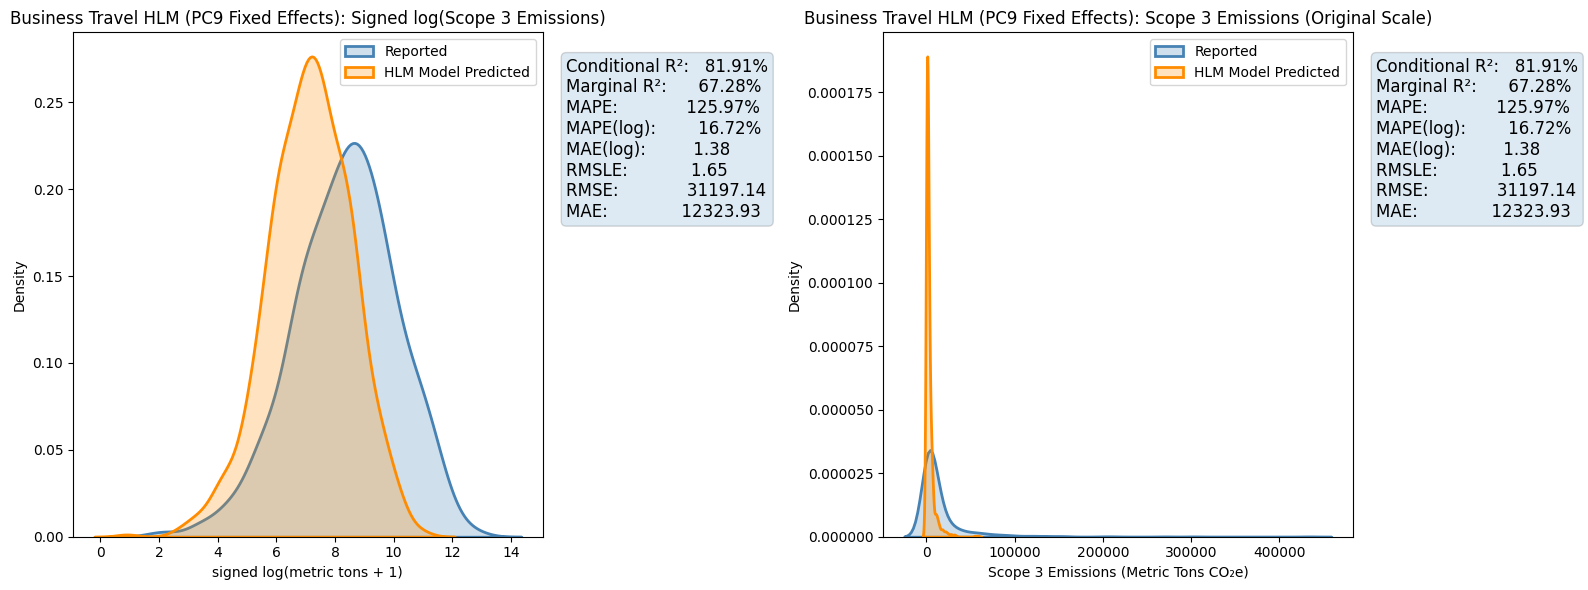

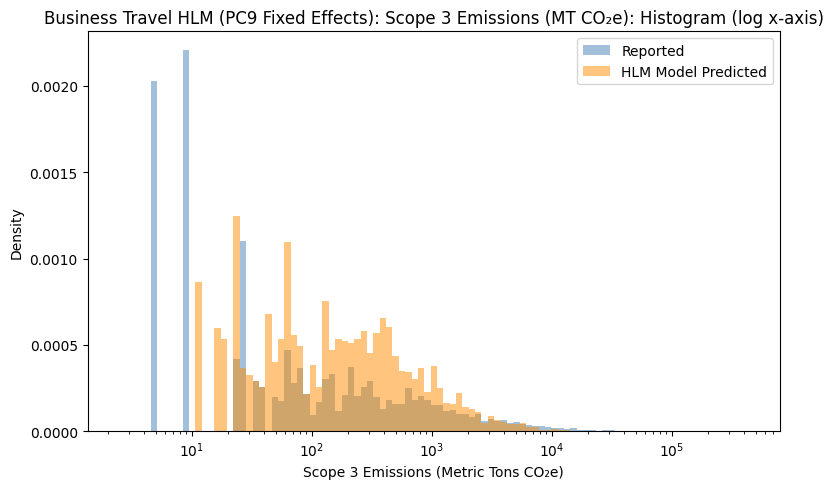

In [12]:
# --- Use train/test splits previously created ---
# train_df_modeling and test_df_modeling contain all PC features and categoricals

# --- 1. Filter for required columns only ---
feature_cols_PC9 = [f'PC9_{i}' for i in range(1, 10)]  # PC9_1 to PC9_9
target_col_PC9 = 'slog_Scope_3_emissions_amount'
cat_cols_PC9 = ['Countries', 'Year', 'account_id', 'Primary_activity']

all_model_vars_PC9 = feature_cols_PC9 + [target_col_PC9] + cat_cols_PC9
train_df_PC9 = train_df_modeling.dropna(subset=all_model_vars_PC9).copy()
test_df_PC9 = test_df_modeling.dropna(subset=all_model_vars_PC9).copy()

# --- 2. Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity']:
    train_cats = set(train_df_PC9[cat_col].unique())
    n_before = len(test_df_PC9)
    test_df_PC9 = test_df_PC9[test_df_PC9[cat_col].isin(train_cats)]
    n_after = len(test_df_PC9)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_PC9.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- 3. Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_PC9) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_PC9} ~ {fixed_effects}'

    # --- 4. Fit the mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_PC9, groups=train_df_PC9['account_id'])
        mdf_PC9 = md.fit(reml=False)
    print(mdf_PC9.summary())

    # --- 5. CALCULATE CONDITIONAL AND MARGINAL R² ---
    var_fixed = np.var(mdf_PC9.fittedvalues)
    var_resid = mdf_PC9.scale
    var_random = mdf_PC9.cov_re.iloc[0, 0] if mdf_PC9.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # --- 6. Predict on test set ---
    test_df_PC9['predicted_log'] = mdf_PC9.predict(test_df_PC9)
    test_df_PC9['predicted'] = np.sign(test_df_PC9['predicted_log']) * (np.expm1(np.abs(test_df_PC9['predicted_log'])))

    # --- 7. Metrics ---
    y_true_log = test_df_PC9[target_col_PC9]
    y_pred_log = test_df_PC9['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_PC9['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nBusiness Travel HLM with PC9 Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # --- 8. Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_PC9.params,
        'pvalue': mdf_PC9.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- 9. Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Business Travel HLM (PC9 Fixed Effects): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Business Travel HLM (PC9 Fixed Effects): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
    plt.xscale("log")
    plt.title("Business Travel HLM (PC9 Fixed Effects): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 10. RETURN METRICS FOR SUMMARY TABLE ---
    PC9_model_metrics = {
        "Model": "HLM PC9",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_PC9),
        "# Obs (test)": len(test_df_PC9),
        "# Obs (train/test)": f"{len(train_df_PC9)}/{len(test_df_PC9)}"
    }

In [13]:
train_df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5019 entries, 0 to 5018
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   5019 non-null   object 
 1   account_id                     5019 non-null   int64  
 2   Year                           5019 non-null   int64  
 3   Countries                      5019 non-null   object 
 4   Primary_activity               5019 non-null   object 
 5   Primary_sector                 5019 non-null   object 
 6   Market_Cap_USD                 4144 non-null   float64
 7   Revenue_USD                    4221 non-null   float64
 8   ebitda_USD                     4221 non-null   float64
 9   grossProfit_USD                4221 non-null   float64
 10  netIncome_USD                  4221 non-null   float64
 11  cashAndCashEquivalents_USD     4221 non-null   float64
 12  shortTermInvestments_USD       4221 non-null   float6

### HLM with 4 Principal Components (PC4) — Business Travel Dataset

- Uses the same train and test splits as the PC9 model, retaining only companies present in both periods.
- Filters for rows with complete PC4, signed-log target, and contextual/categorical data.
- Ensures test set categories match those seen in training.
- Fits a hierarchical linear mixed model (HLM) with PC4 features and contextual variables (year, country, activity) as fixed effects, and company as a random effect.
- Evaluates on the test set with standard regression metrics, feature importances, and visualization.

_Result_:  
Enables HLM modeling and evaluation for business travel emissions using 4 principal components.

                                         Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                slog_Scope_3_emissions_amount
No. Observations:                4130                   Method:                            ML                           
No. Groups:                      874                    Scale:                             0.8099                       
Min. group size:                 1                      Log-Likelihood:                    -6133.0661                   
Max. group size:                 5                      Converged:                         Yes                          
Mean group size:                 4.7                                                                                    
------------------------------------------------------------------------------------------------------------------------
                                                                          

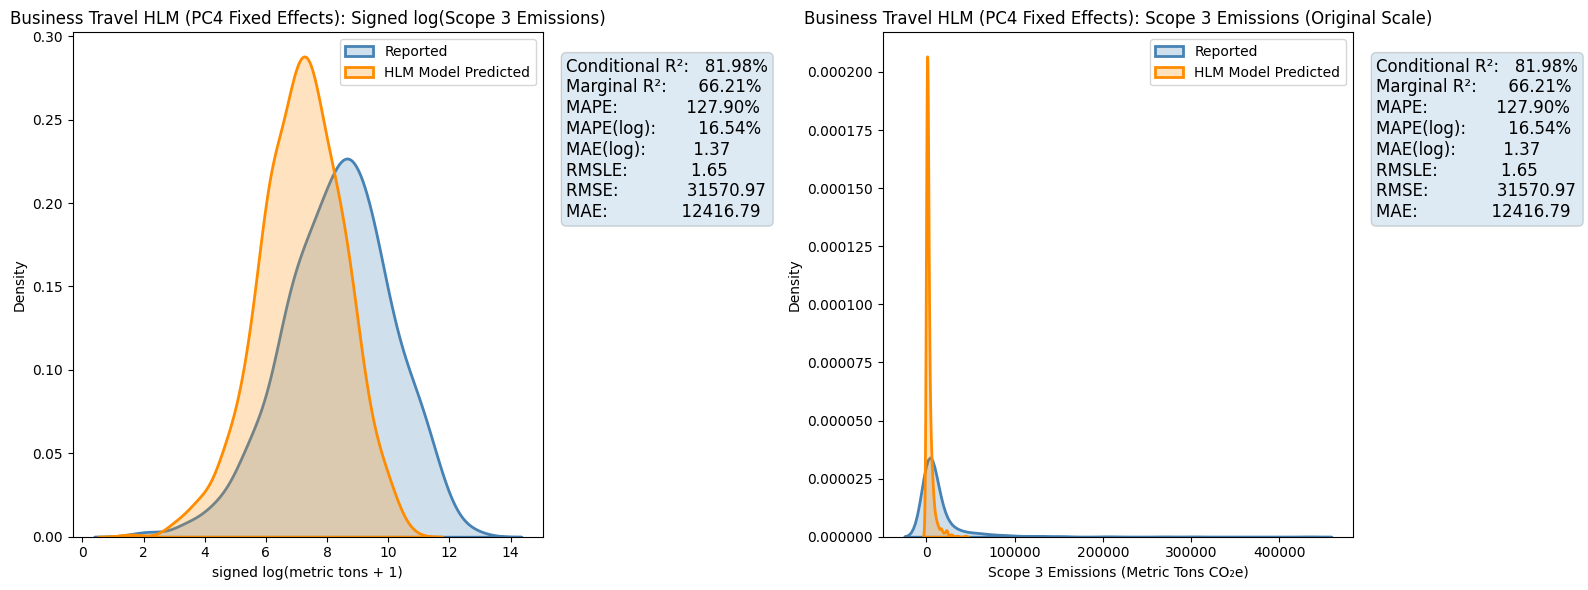

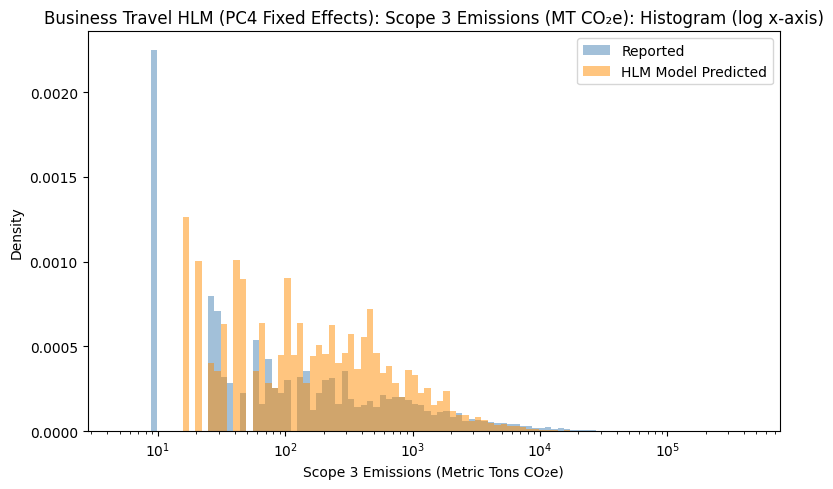

In [14]:
# --- Use train/test splits previously created ---
# train_df_modeling and test_df_modeling contain all PC features and categoricals

# --- 1. Filter for required columns only ---
feature_cols_pc4 = [f'PC4_{i}' for i in range(1, 5)]
target_col_pc4 = 'slog_Scope_3_emissions_amount'
cat_cols_pc4 = ['Countries', 'Year', 'account_id', 'Primary_activity']

all_model_vars_pc4 = feature_cols_pc4 + [target_col_pc4] + cat_cols_pc4
train_df_pc4 = train_df_modeling.dropna(subset=all_model_vars_pc4).copy()
test_df_pc4 = test_df_modeling.dropna(subset=all_model_vars_pc4).copy()

# --- 2. Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity']:
    train_cats = set(train_df_pc4[cat_col].unique())
    n_before = len(test_df_pc4)
    test_df_pc4 = test_df_pc4[test_df_pc4[cat_col].isin(train_cats)]
    n_after = len(test_df_pc4)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_pc4.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- 3. Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_pc4) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_pc4} ~ {fixed_effects}'

    # --- 4. Fit the mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_pc4, groups=train_df_pc4['account_id'])
        mdf_pc4 = md.fit(reml=False)
    print(mdf_pc4.summary())

    # --- 5. CALCULATE CONDITIONAL AND MARGINAL R² ---
    var_fixed = np.var(mdf_pc4.fittedvalues)
    var_resid = mdf_pc4.scale
    var_random = mdf_pc4.cov_re.iloc[0, 0] if mdf_pc4.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # --- 6. Predict on test set ---
    test_df_pc4['predicted_log'] = mdf_pc4.predict(test_df_pc4)
    test_df_pc4['predicted'] = np.sign(test_df_pc4['predicted_log']) * (np.expm1(np.abs(test_df_pc4['predicted_log'])))

    # --- 7. Metrics ---
    y_true_log = test_df_pc4[target_col_pc4]
    y_pred_log = test_df_pc4['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_pc4['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nBusiness Travel HLM with PC4 Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # --- 8. Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_pc4.params,
        'pvalue': mdf_pc4.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- 9. Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Business Travel HLM (PC4 Fixed Effects): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Business Travel HLM (PC4 Fixed Effects): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
    plt.xscale("log")
    plt.title("Business Travel HLM (PC4 Fixed Effects): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 10. RETURN METRICS FOR SUMMARY TABLE ---
    pc4_model_metrics = {
        "Model": "HLM PC4",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_pc4),
        "# Obs (test)": len(test_df_pc4),
        "# Obs (train/test)": f"{len(train_df_pc4)}/{len(test_df_pc4)}"
    }

Four pc's provides very similar Conditional and Marginal R^2 values and similar error metrics.  Four pc's are more optimal for simplification.<br>
Now I'll look into hierarchical clustering to determine if that may add value to increasing prediction accuracy.

In [15]:
business_travel_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6060 entries, 0 to 6059
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   6060 non-null   object 
 1   account_id                     6060 non-null   int64  
 2   Year                           6060 non-null   int64  
 3   Countries                      6060 non-null   object 
 4   Primary_activity               6060 non-null   object 
 5   Primary_sector                 6060 non-null   object 
 6   Market_Cap_USD                 5034 non-null   float64
 7   Revenue_USD                    5075 non-null   float64
 8   ebitda_USD                     5075 non-null   float64
 9   grossProfit_USD                5075 non-null   float64
 10  netIncome_USD                  5075 non-null   float64
 11  cashAndCashEquivalents_USD     5075 non-null   float64
 12  shortTermInvestments_USD       5075 non-null   f

### Hierarchical Clustering on 4 Principal Components (PC4) — Business Travel Dataset

1. **Feature Selection**
    - Select PC4 features from the PCA-enriched dataset, dropping any rows with missing PC4 data.
2. **Standardization**
    - Standardize the selected PC4 features before clustering.
3. **Agglomerative Clustering**
    - Apply hierarchical clustering using Ward linkage on the standardized PC4 data.
4. **Cluster Selection**
    - Evaluate clusterings for 2 to 30 clusters using silhouette scores; select the number of clusters with the highest score.
    - Plot silhouette scores by cluster count.
5. **Cluster Assignment**
    - Assign the optimal cluster labels to the main DataFrame (for rows used in clustering).
    - Print the number of observations per cluster.
6. **Visualization**
    - Optionally, plot a truncated dendrogram to visualize the hierarchical clustering structure.

---

**Result:**  
Cluster assignments are added to the business travel dataset, enabling downstream modeling and analysis of group structure based on multivariate PC4 patterns.

Optimal number of clusters (highest silhouette score): 3


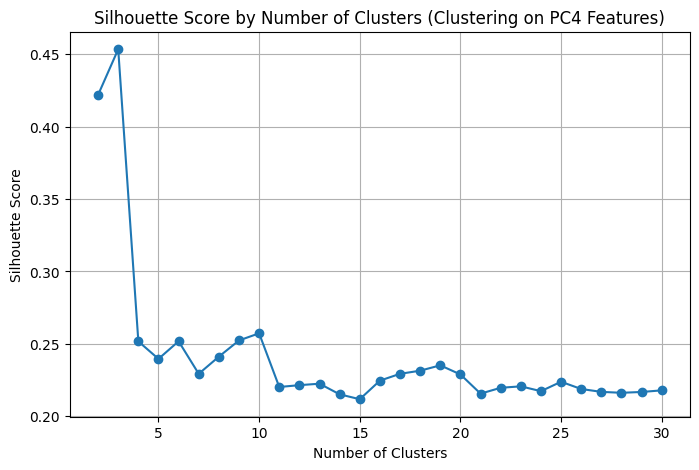

Number of observations in each cluster:
3    4329
1     472
2     170
Name: count, dtype: int64


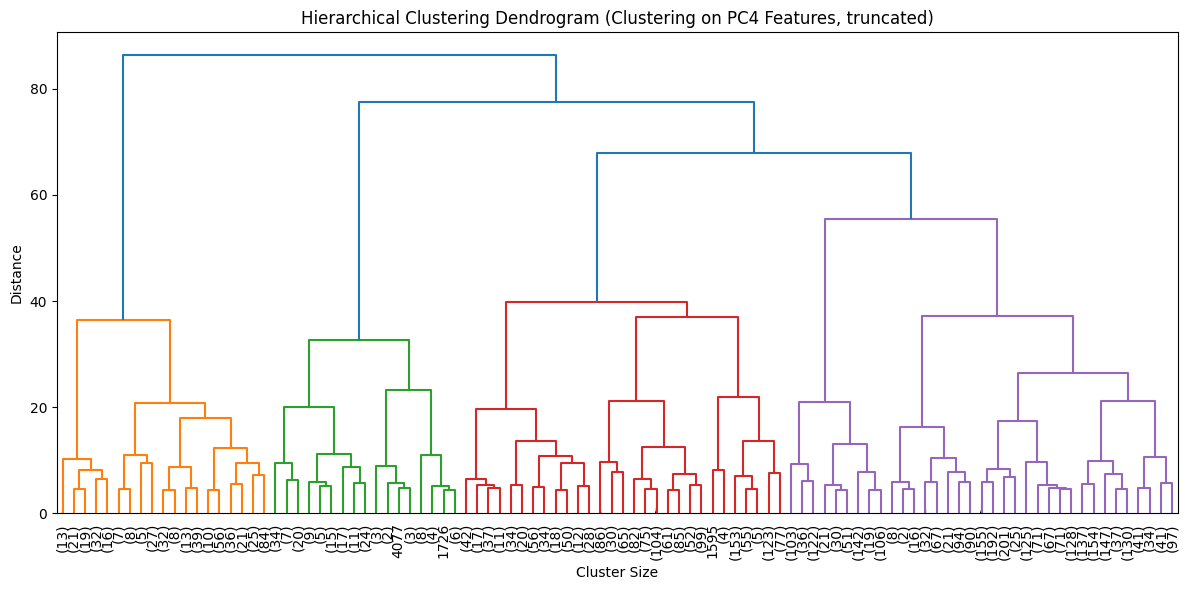

In [16]:
# --- STEP 1: Select PC4 PCA components for clustering ---
pc4_cols = [f'PC4_{i}' for i in range(1, 5)]
X_pc4 = business_travel_pca[pc4_cols].dropna()
clust_indices = X_pc4.index

# --- STEP 2: Standardize the PC4 data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pc4)

# --- STEP 3: Hierarchical clustering (Ward linkage) ---
Z = linkage(X_scaled, method='ward')

# --- STEP 4: Find optimal number of clusters using silhouette score ---
range_n_clusters = range(2, 31)  # 2 to 30 clusters
sil_scores = []

for n_clusters in range_n_clusters:
    labels = fcluster(Z, n_clusters, criterion='maxclust')
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

optimal_n_clusters = range_n_clusters[np.argmax(sil_scores)]
print(f"Optimal number of clusters (highest silhouette score): {optimal_n_clusters}")

# --- Plot silhouette scores ---
plt.figure(figsize=(8,5))
plt.plot(range_n_clusters, sil_scores, marker='o')
plt.title('Silhouette Score by Number of Clusters (Clustering on PC4 Features)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# --- STEP 5: Assign optimal cluster labels ---
labels_optimal = fcluster(Z, optimal_n_clusters, criterion='maxclust')

# --- STEP 6: Append cluster labels back to original DataFrame (only for valid rows) ---
business_travel_pca_clusters = business_travel_pca.copy()
business_travel_pca_clusters['Cluster'] = np.nan  # initialize with NaN
business_travel_pca_clusters.loc[clust_indices, 'Cluster'] = labels_optimal

# --- Print cluster counts ---
print("Number of observations in each cluster:")
print(pd.Series(labels_optimal).value_counts())

# --- Optionally plot dendrogram (subset for readability) ---
plt.figure(figsize=(12, 6))
sample_size = min(100, len(X_scaled))  # Plot up to 100 samples for clarity
dendrogram(Z, truncate_mode='lastp', p=sample_size, leaf_rotation=90, leaf_font_size=10, show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Clustering on PC4 Features, truncated)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [17]:
business_travel_pca_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6060 entries, 0 to 6059
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_name                   6060 non-null   object 
 1   account_id                     6060 non-null   int64  
 2   Year                           6060 non-null   int64  
 3   Countries                      6060 non-null   object 
 4   Primary_activity               6060 non-null   object 
 5   Primary_sector                 6060 non-null   object 
 6   Market_Cap_USD                 5034 non-null   float64
 7   Revenue_USD                    5075 non-null   float64
 8   ebitda_USD                     5075 non-null   float64
 9   grossProfit_USD                5075 non-null   float64
 10  netIncome_USD                  5075 non-null   float64
 11  cashAndCashEquivalents_USD     5075 non-null   float64
 12  shortTermInvestments_USD       5075 non-null   f

### Data Split with Clusters — Business Travel Dataset

- Incorporates the `Cluster` feature (from hierarchical clustering on PC4) along with all original, numeric, and principal component features.
- Drops rows with missing values in any required column, including `Cluster`.
- Applies a signed-log transformation to all numeric features (original and principal components).
- Splits the data into train (2018–2022) and test (2023) sets, restricting the test set to companies present in the training set.

_Result_:  
`train_df` and `test_df` are prepared for downstream modeling, with complete feature coverage and cluster labels included.

In [18]:
# --- Define numeric columns of interest ---
numeric_cols = [
    'Market_Cap_USD',
    'Revenue_USD',
    'totalAssets_USD',
    'totalLiabilities_USD',
    'totalInvestments_USD',
    'totalDebt_USD',
    'totalEquity_USD',
    'ebitda_USD',
    'Scope_3_emissions_amount',
    'scope_1_2_emissions_amount'
]

# Add principal component columns if they exist (e.g., PC9_1...PC9_9 and/or PC4_1...PC4_4)
pc_cols = [col for col in business_travel_pca_clusters.columns if col.startswith("PC")]
numeric_cols_all = numeric_cols + pc_cols

# Required categorical columns
required_cols = [
    'account_id', 'Year', 'Countries', 'Primary_activity', 'Cluster'
] + numeric_cols_all

# --- Prepare Data: filter and drop rows with missing required columns ---
df = business_travel_pca_clusters[required_cols].dropna().copy()

# --- Signed log transform on all numeric columns ---
def signed_log(x):
    return np.sign(x) * np.log(np.abs(x) + 1)

for col in numeric_cols_all:
    df[f'slog_{col}'] = signed_log(df[col])

# --- Company-level split by year ---
train_df = df[df['Year'].between(2018, 2022)].copy()
test_df  = df[df['Year'] == 2023].copy()

# Restrict test set to companies present in training set
valid_companies = set(train_df['account_id'].unique())
test_df = test_df[test_df['account_id'].isin(valid_companies)].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (4130, 51)
Test shape: (789, 51)


### HLM with 4 Principal Components (PC4) and Cluster — Business Travel Dataset

- Uses train and test splits that include the `Cluster` feature (from hierarchical clustering on PC4), as well as all principal components and relevant categorical features.
- Drops rows with missing values in any required field.
- Ensures all categorical levels in the test set are present in the training set, including `Cluster`.
- Fits a hierarchical linear mixed model (HLM) with PC4 features and `Cluster` as fixed effects, plus contextual variables (year, country, activity), and company as a random effect.
- Evaluates on the test set, reporting regression metrics, feature importances, and visualizations.

_Result_:  
Enables mixed-effects modeling of business travel emissions using both principal components and cluster groupings for improved interpretability and predictive performance.

                                         Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                slog_Scope_3_emissions_amount
No. Observations:                4130                   Method:                            ML                           
No. Groups:                      874                    Scale:                             0.8085                       
Min. group size:                 1                      Log-Likelihood:                    -6127.8802                   
Max. group size:                 5                      Converged:                         Yes                          
Mean group size:                 4.7                                                                                    
------------------------------------------------------------------------------------------------------------------------
                                                                          

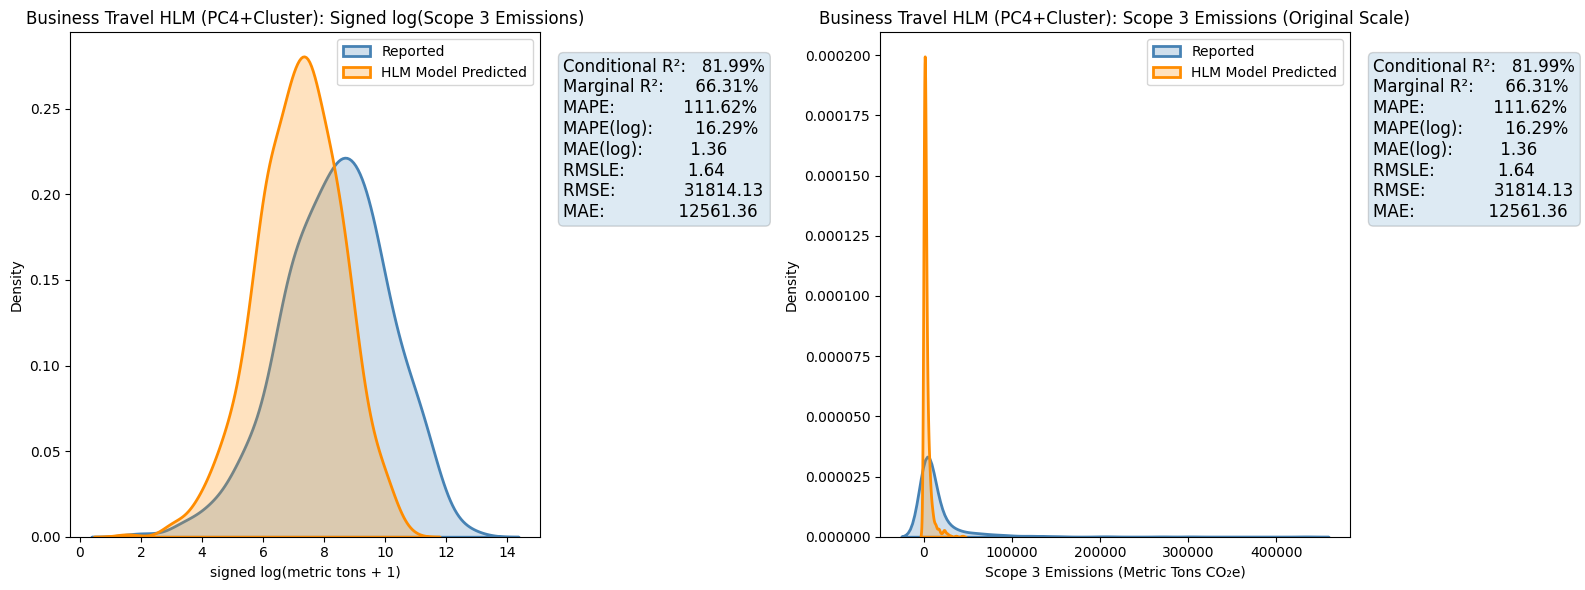

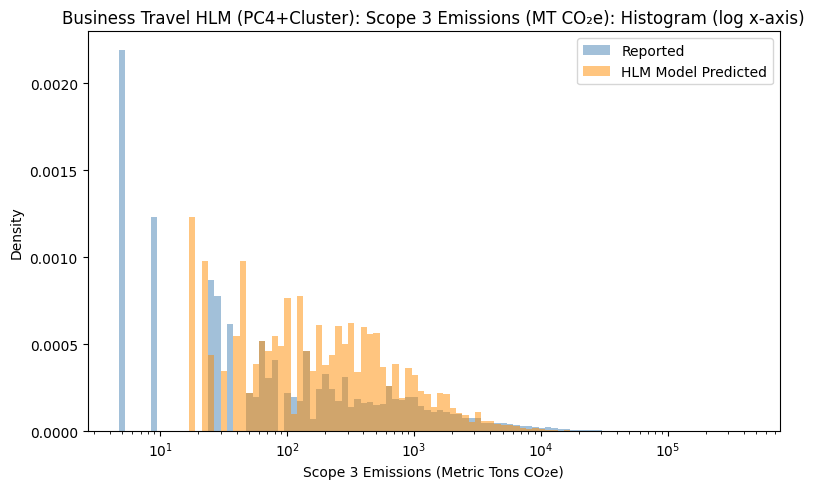

In [19]:
# --- PC4 + Cluster HLM ---

# --- Use the newly created train_df and test_df which include 'Cluster' ---
# Assumes train_df and test_df created in the previous step with Cluster and all required features

feature_cols_pc4_cluster = [f'PC4_{i}' for i in range(1, 5)] + ['Cluster']
target_col = 'slog_Scope_3_emissions_amount'
cat_cols = ['Countries', 'Year', 'account_id', 'Primary_activity']
all_model_vars = feature_cols_pc4_cluster + [target_col] + cat_cols

# --- Drop any remaining missing values ---
train_df_pc4c = train_df.dropna(subset=all_model_vars).copy()
test_df_pc4c  = test_df.dropna(subset=all_model_vars).copy()

# --- Ensure all categorical levels in test are present in train ---
for cat_col in ['Countries', 'Primary_activity', 'Cluster']:
    train_cats = set(train_df_pc4c[cat_col].unique())
    n_before = len(test_df_pc4c)
    test_df_pc4c = test_df_pc4c[test_df_pc4c[cat_col].isin(train_cats)]
    n_after = len(test_df_pc4c)
    if n_after < n_before:
        print(f"Warning: Dropped {n_before - n_after} test rows with unseen {cat_col} categories.")

if test_df_pc4c.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join([f'C({col})' if col == 'Cluster' else col for col in feature_cols_pc4_cluster]) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col} ~ {fixed_effects}'

    # --- Fit the mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_pc4c, groups=train_df_pc4c['account_id'])
        mdf_pc4c = md.fit(reml=False)
    print(mdf_pc4c.summary())

    # --- CALCULATE CONDITIONAL AND MARGINAL R² ---
    var_fixed = np.var(mdf_pc4c.fittedvalues)
    var_resid = mdf_pc4c.scale
    var_random = mdf_pc4c.cov_re.iloc[0, 0] if mdf_pc4c.cov_re.shape[0] > 0 else 0.0
    var_random_total = var_random

    r2_marginal = var_fixed / (var_fixed + var_random_total + var_resid)
    r2_conditional = (var_fixed + var_random_total) / (var_fixed + var_random_total + var_resid)

    print(f"Marginal R² (fixed only):      {r2_marginal:.4f}")
    print(f"Conditional R² (fixed+random): {r2_conditional:.4f}")

    # --- Predict on test set ---
    test_df_pc4c['predicted_log'] = mdf_pc4c.predict(test_df_pc4c)
    test_df_pc4c['predicted'] = np.sign(test_df_pc4c['predicted_log']) * (np.expm1(np.abs(test_df_pc4c['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_pc4c[target_col]
    y_pred_log = test_df_pc4c['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_pc4c['predicted']

    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)

    metrics_text = (
        f"Conditional R²:   {r2_conditional*100:.2f}%\n"
        f"Marginal R²:      {r2_marginal*100:.2f}%\n"
        f"MAPE:             {mape_orig:.2f}%\n"
        f"MAPE(log):        {mape_log:.2f}%\n"
        f"MAE(log):         {mae_log:.2f}\n"
        f"RMSLE:            {rmsle:.2f}\n"
        f"RMSE:             {rmse_orig:.2f}\n"
        f"MAE:              {mae_orig:.2f}"
    )

    print("\nBusiness Travel HLM with PC4+Cluster Fixed Effects: Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_pc4c.params,
        'pvalue': mdf_pc4c.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))
    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Business Travel HLM (PC4+Cluster): Signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()
    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='HLM Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Business Travel HLM (PC4+Cluster): Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()
    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))
    plt.tight_layout()
    plt.show()
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)
    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="HLM Model Predicted")
    plt.xscale("log")
    plt.title("Business Travel HLM (PC4+Cluster): Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- RETURN METRICS FOR SUMMARY TABLE ---
    pc4_cluster_model_metrics = {
        "Model": "HLM PC4+Cluster",
        "Conditional_R2": r2_conditional,
        "Marginal_R2": r2_marginal,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "MAE_log": mae_log,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "# Obs (train)": len(train_df_pc4c),
        "# Obs (test)": len(test_df_pc4c),
        "# Obs (train/test)": f"{len(train_df_pc4c)}/{len(test_df_pc4c)}"
    }

### Model Metrics Summary: Business Travel HLM Models

In [23]:
# Collect metrics dicts from each model; change names as needed
metrics_dicts = [
    PC9_model_metrics,        # e.g., "HLM PC9"
    pc4_model_metrics,        # e.g., "HLM PC4"
    pc4_cluster_model_metrics # e.g., "HLM PC4 + Cluster"
]

# Attach observation counts, convergence info, and explained variance to each dictionary
for metrics, train, test, model, explained_var in zip(
        metrics_dicts,
        [train_df, train_df, train_df],   # each model's actual train split
        [test_df, test_df, test_df],      # each model's actual test split
        [mdf_PC9, mdf_pc4, mdf_pc4c],     # each model object (if available)
        [
            sum(pca9.explained_variance_ratio_),    # PC9 explained variance
            sum(pca4.explained_variance_ratio_),    # PC4 explained variance
            sum(pca4.explained_variance_ratio_)     # PC4 (cluster uses same PC4)
        ]):
    metrics["# Obs (train)"] = len(train)
    metrics["# Obs (test)"] = len(test)
    metrics["# Obs (train/test)"] = f"{len(train)}/{len(test)}"
    metrics["Converged"] = bool(getattr(model, "converged", False))
    metrics["PC Explained Variance"] = explained_var

# Add a new row for your "Optimized" model
optimized_row = {
    "Model": "Optimized Business Travel HLM",
    "Conditional_R2": 0.7291,
    "Marginal_R2": 0.5946,
    "RMSE": 24942.9,
    "MAE": 9431.47,
    "MAE_log": 0.83,
    "RMSLE": 1.1,
    "MAPE": 223.74,
    "# Obs (train)": 4130,
    "# Obs (test)": 789,
    "# Obs (train/test)": "4130/789",
    "PC Explained Variance": np.nan,
    "Converged": True
}
metrics_dicts.append(optimized_row)

metrics_df = pd.DataFrame(metrics_dicts)

# Order columns for summary, with variance before Converged
desired_order = [
    "Model", "PC Explained Variance", "Conditional_R2", "Marginal_R2", "RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "# Obs (train/test)", "Converged"
]

# Add MAE_log or MAPE(log) if missing
for col in ["MAE_log", "MAPE(log)"]:
    if col not in metrics_df.columns:
        metrics_df[col] = np.nan

metrics_df = metrics_df[[col for col in desired_order if col in metrics_df.columns]]

# Format for display
metrics_df_display = metrics_df.copy()
if "Conditional_R2" in metrics_df_display.columns:
    metrics_df_display["Conditional_R2"] = (metrics_df_display["Conditional_R2"].astype(float) * 100).map("{:.2f}%".format)
if "Marginal_R2" in metrics_df_display.columns:
    metrics_df_display["Marginal_R2"] = (metrics_df_display["Marginal_R2"].astype(float) * 100).map("{:.2f}%".format)
for col in ["RMSE", "MAE", "MAE_log", "RMSLE", "MAPE"]:
    if col in metrics_df_display.columns:
        metrics_df_display[col] = metrics_df_display[col].astype(float).map("{:.2f}".format)
if "PC Explained Variance" in metrics_df_display.columns:
    metrics_df_display["PC Explained Variance"] = metrics_df_display["PC Explained Variance"].apply(
        lambda v: "{:.2%}".format(v) if pd.notnull(v) else ""
    )
if "Converged" in metrics_df_display.columns:
    metrics_df_display["Converged"] = metrics_df_display["Converged"].map({True: "Yes", False: "No", np.nan: ""})

# Display in notebook or print
try:
    display(metrics_df_display)
except Exception:
    print(metrics_df_display.to_string(index=False))

,Model,PC Explained Variance,Conditional_R2,Marginal_R2,RMSE,MAE,MAE_log,RMSLE,MAPE,# Obs (train/test),Converged
0,HLM PC9,90.05%,81.91%,67.28%,31197.14,12323.93,1.38,1.65,125.97,4130/789,Yes
1,HLM PC4,62.13%,81.98%,66.21%,31570.97,12416.79,1.37,1.65,127.90,4130/789,Yes
2,HLM PC4+Cluster,62.13%,81.99%,66.31%,31814.13,12561.36,1.36,1.64,111.62,4130/789,Yes
3,Optimized Business Travel HLM,,72.91%,59.46%,24942.90,9431.47,0.83,1.10,223.74,4130/789,Yes
